# Mask Distribution Problem
- Essencially we solve two separate problems; 1) mask for young population and 2) mask for adults population
- Assumption: the total supply is insuffienct to satisfy all demands from the pharmacy
- Objective 1: maximize the total utility (for social welfare)
- Objecitve 2: minimize the total inequity (for fairness)

## Read data from csv file

In [12]:
import pandas as pd
data = pd.read_csv('data.csv') 
data.iloc[0:10,:]

,location_id,address_1,address_2,address_3,n_pharmacies,n_young,n_adults,n_elders,intensity
0,1,1,1,1,5,402,2206,116,0.656476
1,2,1,1,2,3,530,2865,807,0.766949
2,3,1,1,3,4,300,2248,900,0.352150
3,4,1,2,1,4,960,2892,538,0.450202
4,5,1,2,2,5,129,882,289,0.757943
5,6,2,1,1,2,196,1311,296,0.574397
6,7,2,1,2,4,778,2793,530,0.390618
7,8,2,1,3,3,245,2555,242,0.993306
8,9,2,2,1,2,1000,2271,265,0.894212
9,10,2,2,2,4,632,1881,712,0.192206


### Data processing
- create pharmacy data: each pharmacy has the same number of population for each class within the same area (location_id)

In [26]:
import numpy as np
n = data.shape[0] # number of total locations
m = data['n_pharmacies'].sum()
pharm_data =  pd.DataFrame([],index=range(0,m), columns=['pharmacy_id', 'location_id', 'n_young','n_adults','n_elders'])
print(pharm_data.shape)
counter = 0
for i in range(n):
    nn = data.iloc[i,4]
    for j in range(nn):
        
        pharm_data.iloc[counter,0] = counter + 1
        pharm_data.iloc[counter,1] = data.iloc[i,0]
        pharm_data.iloc[counter,2] = np.ceil(data.iloc[i,5]/nn)
        pharm_data.iloc[counter,3] = np.ceil(data.iloc[i,6]/nn)
        pharm_data.iloc[counter,4] = np.ceil(data.iloc[i,7]/nn)
        counter = counter + 1
pharm_data.iloc[0:10,]

(36, 5)


,pharmacy_id,location_id,n_young,n_adults,n_elders
0,1,1,81,442,24
1,2,1,81,442,24
2,3,1,81,442,24
3,4,1,81,442,24
4,5,1,81,442,24
5,6,2,177,955,269
6,7,2,177,955,269
7,8,2,177,955,269
8,9,3,75,562,225
9,10,3,75,562,225


### total supply 
- total quantities are insufficient

In [8]:
import numpy as np
supply_young = np.ceil(0.5*data['n_young'].sum())
supply_adults = np.ceil(0.5*(data['n_adults'].sum()+data['n_elders'].sum()))
print(supply_young) # I arbitrarily set 50% of shortage
print(supply_adults)

2999.0
11801.0


### construct two utility functions for each pharmacy 
- we assume that each pharmacy in the same 'dong' area has the same number of (potential) customers
- e.g. An area has 100 population and 2 pharmacies. Then, pharmacy 1 and 2 covers 50 and 50 population respectively in this area.
- Each pharmacy has two utility functions; 1) utility function for young population (age below 15) and 2) utility for adults inclding elders (age above 65). 
- utiliy function is consisted of total population, number of breakpoints, population for each class, slope, max utility
- Each area has an intensity which shows the level of threat for COVID-19. (higher value represents higher threat)
- to begin with, we focus on the problem of the adults below.

In [13]:
n = data.shape[0] # number of total locations
print("The number of ('dong') locations is %d." % n)

The number of pharmacies is 10.


In [27]:
m = pharm_data.shape[0] # number of total pharmacies
print("The number of pharmacies is %d." % m)

The number of pharmacies is 36.


In [85]:
total_area_population = data[['location_id', 'n_adults']].copy()  #total number of population of each "dong"
for i in range(n):
    total_area_population.iloc[i,1] = data.iloc[i,6] + data.iloc[i,7]


,location_id,n_adults
0,1,2322
1,2,3672
2,3,3148
3,4,3430
4,5,1171


In [87]:
total_population = np.zeros(m) #total number of beds of each pharmacy
for i in range(m):
    total_population[i] = pharm_data.iloc[i,3] + pharm_data.iloc[i,4]
print(total_population[1:10])

[ 466.  466.  466.  466. 1224. 1224. 1224.  787.  787.]


In [28]:
num_breaks = np.zeros(m) #number of breakpoints of the utility function for each pharmacy
for i in range(m):
    num_breaks[i] = 2

In [36]:
sub_population = np.zeros([m,2]) # number of capacity of each class (adults and elders) for each pharmacy
for i in range(m):
    sub_population[i,0] = pharm_data.iloc[i,4] # number of elders (they have a higher priority)
    sub_population[i,1] = pharm_data.iloc[i,3] # number of adults

print(sub_population[0:10,:])

[[ 24. 442.]
 [ 24. 442.]
 [ 24. 442.]
 [ 24. 442.]
 [ 24. 442.]
 [269. 955.]
 [269. 955.]
 [269. 955.]
 [225. 562.]
 [225. 562.]]


- slope means the utility for one customer of each class (higher slope means higher benefit)

In [ ]:
slope = np.zeros([m,2]) # number of slope of each class (adults and elders) for each pharmacy
for i in range(m):
    a = data.loc[data['location_id']==pharm_data.iloc[i,1],'intensity']
    temp_intensity = a.iloc[0] # obtain the intensity for the i-th pharmacy
    slope[i,0] = 2 * temp_intensity#* data.iloc[i,6] #second term adjusts the utility slope 
    slope[i,1] = 1 * temp_intensity#* data.iloc[i,7]
print(slope[1:10,:])

- maximum utility of each pharmacy (this is needed for future computation of the gini index)

In [54]:
max_utility = np.zeros(m)
for i in range(m):
    max_utility[i] = sub_population[i,0]*slope[i,0]+sub_population[i,1]*slope[i,1]
print(max_utility[0:10])

[ 321.67299843  321.67299843  321.67299843  321.67299843  321.67299843
 1145.05434042 1145.05434042 1145.05434042  356.3761289   356.3761289 ]


## (Sample) utility funtion graph

[  0.  24. 442.] [  0.          31.51082434 321.67299843]


Text(0.5, 0.98, 'A sample utility function of pharmacy')

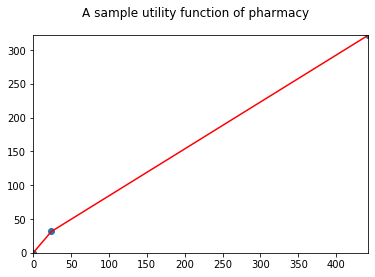

In [84]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.array([0, sub_population[0,0],sub_population[0,1]], dtype=float)
y = np.array([0, sub_population[0,0]*slope[0,0],sub_population[0,0]*slope[0,0]+sub_population[0,1]*slope[0,1] ])

print(x,y)
fig, ax = plt.subplots()

plt.xlim([0, x[2]])
plt.ylim([0, y[2]])
plt.scatter(x, y)
plt.plot(x, y,"r")
fig.suptitle('A sample utility function of pharmacy', fontsize=12)

## Solve a bi-criteria optimization using $\epsilon$-constraint method

In [161]:
from docplex.mp.model import Model

def solve_problem(epsilon,supply,total_population,num_breaks,sub_population,slope,max_utility):
    flag = 1 # if optimal solution is found: 0, otherwise 1.
    numPharmacies = total_population.shape[0] # number of pharmacies
    N = [i for i in range(numPharmacies)] #define set
    M = [i for i in range(int(num_breaks[0]))] #define set for break points 
    A = [(i,t) for i in range(numPharmacies) for t in range(int(num_breaks[0]))] #define set for x_i^t
    B = [(j,k) for j in range(numPharmacies) for k in range(numPharmacies) if k>j]
    
    mdl = Model("lp")
    # define variables
    x = mdl.integer_var_dict(A,name='x')
    d_plus = mdl.continuous_var_dict(B,name='d_plus')
    d_minus = mdl.continuous_var_dict(B,name='d_minus')
    
    # define objecitve function 
    mdl.maximize(mdl.sum(slope[i,t]*x[i,t] for i,t in A))
    #print(mdl.get_objective_expr())
    # define constraints 
    mdl.add_constraint(mdl.sum(x[i,t] for i,t in A) <= supply,"constraint1") #total shipped quantities is less than supply
    #print(mdl.get_constraint_by_name("constraint1"))
    for i,t in A:
        mdl.add_constraint(x[i,t]<=sub_population[i,t]) # resriction of shipped quantiies for each interval 
    for i in N: # this constraint maybe redundant because of the previous interval restriction
        mdl.add_constraint(mdl.sum(x[i,t] for t in M) <= total_population[i], ctname='constraint2_%d'% i) # shipped quantities is less than hospital capacity
        #print(mdl.get_constraint_by_name("constraint2_%d"% i))
    for j,k in B:
        mdl.add_constraint(d_plus[j,k]-d_minus[j,k]==max_utility[j]*mdl.sum(slope[k,t]*x[k,t] for t in M)-max_utility[k]*mdl.sum(slope[j,t]*x[j,t] for t in M),ctname='constraint3_%d_%d'% (j,k))
        #print(mdl.get_constraint_by_name("constraint3_%d_%d"% (j,k)))
    mdl.add_constraint(mdl.sum(d_plus[j,k]+d_minus[j,k] for j,k in B)<=epsilon*mdl.sum(max_utility[i] for i in N)*mdl.sum(slope[i,t]*x[i,t] for i,t in A))
    
    solution = mdl.solve(log_output=False)
    #print(solution)
    x_sol = solution.get_value_dict(x)
    x_sol_list = list(x_sol.values())
    #print(x_sol_list)
    d_plus = solution.get_value_dict(d_plus)
    d_plus_list = list(d_plus.values())
    #print(d_plus_list)
    d_minus = solution.get_value_dict(d_minus)
    d_minus_list = list(d_minus.values())
    #print(d_minus_list)
    flag = solution.solve_status
    #print(flag)
    optObj = solution.objective_value
    #print(optObj)
    return x_sol,d_plus,d_minus,optObj,flag

### solve the problem with epsilon value

In [110]:
epsilon = 0.1

In [151]:
x,d_plus,d_minus,obj_val,flag = solve_problem(epsilon,supply_adults,total_population,num_breaks,sub_population,slope,max_utility)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Found incumbent of value 0.000000 after 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 108 rows and 0 columns.
MIP Presolve modified 210 coefficients.
Reduced MIP has 632 rows, 1332 columns, and 5114 nonzeros.
Reduced MIP has 0 binaries, 72 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (3.69 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 632 rows, 1332 columns, and 5114 nonzeros.
Reduced MIP has 0 binaries, 72 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.55 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.03 sec. (15.05 ticks)

        Nodes                                         Cuts/
   Node  Left     Object

In [158]:
def restore_values(numPharmacies,x,d_plus,d_minus,obj_val):

    num_value = 0 
    for j in range(numPharmacies):
        for k in range(numPharmacies):
            if k>j:
                num_value = num_value + d_plus[(j,k)] + + d_minus[(j,k)]
    #print(num_value)
    denom_value_1 = 0 
    for i in range(numPharmacies):
        denom_value_1 = denom_value_1 + max_utility[i]
    #print(denom_value_1)
    denom_value_2 = 0 
    for i in range(numPharmacies):
        for t in range(int(num_breaks[0])):
            denom_value_2 = denom_value_2 + slope[i,t]*x[i,t]
    #print(denom_value_2)
    gini = num_value/(denom_value_1*denom_value_2)
    # print(gini)
    return gini, obj_val

In [159]:
gini, obj_val  = restore_values(numPharmacies,x,d_plus,d_minus,obj_val)
print(gini)
print(obj_val)

0.09997559923453471
10421.774607971001


## Obtain a trade-off curve between inequity vs. utility

In [171]:
B = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
results =  pd.DataFrame([],index=range(0,len(B)), columns=['epsilon', 'inequity', 'utility'])
for i in range(len(B)):
    epsilon = B[i]
    #print(epsilon)
    x,d_plus,d_minus,obj_val,flag = solve_problem(epsilon,supply_adults,total_population,num_breaks,sub_population,slope,max_utility)
    gini, obj_val  = restore_values(numPharmacies,x,d_plus,d_minus,obj_val)
    results.iloc[i,0] = epsilon
    results.iloc[i,1] = gini
    results.iloc[i,2] = obj_val
    
print(results.iloc[0:len(B)])

  epsilon    inequity  utility
0    0.01  0.00999993  9715.66
1    0.05   0.0499911  10039.9
2     0.1   0.0999756  10421.8
3    0.15    0.149999  10807.7
4     0.2    0.199969  11118.9
5    0.25    0.249947  11344.9
6     0.3    0.299985    11514
7    0.35     0.33524  11564.8
8     0.4     0.33524  11564.8


Text(0.5, 0.98, 'A trade-off curve')

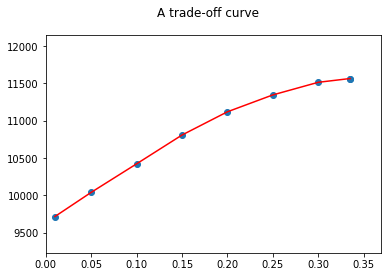

In [175]:
fig, ax = plt.subplots()
plt.xlim([0, 1.1* results['inequity'].max()])
plt.ylim([0.95*results['utility'].min(), 1.05*results['utility'].max()])
plt.scatter(results['inequity'], results['utility'])
plt.plot(results['inequity'], results['utility'],"r")
fig.suptitle('A trade-off curve', fontsize=12)

## Restore the solution

In [179]:
allocation_result =  pd.DataFrame([],index=range(0,m), columns=['pharmacy_id','n_adults','n_elders','allocation_qty'])
print("epsilon value is %5.2f" % epsilon)
for i in range(m):
    temp_x = 0 
    for t in range(int(num_breaks[0])):
        temp_x = temp_x + x[(i,t)]
        
    allocation_result.iloc[i,0] = i
    allocation_result.iloc[i,1] = pharm_data.iloc[i,3]
    allocation_result.iloc[i,2] = pharm_data.iloc[i,4]
    allocation_result.iloc[i,3] = temp_x

print(allocation_result)

epsilon value is  0.40
   pharmacy_id n_adults n_elders allocation_qty
0            0      442       24             24
1            1      442       24             24
2            2      442       24             24
3            3      442       24             24
4            4      442       24             24
5            5      955      269           1224
6            6      955      269           1224
7            7      955      269           1224
8            8      562      225              0
9            9      562      225              0
10          10      562      225              0
11          11      562      225            129
12          12      723      135            135
13          13      723      135            135
14          14      723      135            135
15          15      723      135            135
16          16      177       58            235
17          17      177       58            235
18          18      177       58            235
19          19   

In [181]:
epsilon=0.05
x,d_plus,d_minus,obj_val,flag = solve_problem(epsilon,supply_adults,total_population,num_breaks,sub_population,slope,max_utility)
gini, obj_val  = restore_values(numPharmacies,x,d_plus,d_minus,obj_val)
allocation_result =  pd.DataFrame([],index=range(0,m), columns=['pharmacy_id','n_adults','n_elders','allocation_qty'])
print("epsilon value is %5.2f" % epsilon)
for i in range(m):
    temp_x = 0 
    for t in range(int(num_breaks[0])):
        temp_x = temp_x + x[(i,t)]
        
    allocation_result.iloc[i,0] = i
    allocation_result.iloc[i,1] = pharm_data.iloc[i,3]
    allocation_result.iloc[i,2] = pharm_data.iloc[i,4]
    allocation_result.iloc[i,3] = temp_x

print(allocation_result)


epsilon value is  0.05
   pharmacy_id n_adults n_elders allocation_qty
0            0      442       24            265
1            1      442       24            265
2            2      442       24            265
3            3      442       24            265
4            4      442       24            265
5            5      955      269            613
6            6      955      269            613
7            7      955      269            613
8            8      562      225            225
9            9      562      225            225
10          10      562      225            225
11          11      562      225            225
12          12      723      135            379
13          13      723      135            379
14          14      723      135            379
15          15      723      135            379
16          16      177       58            115
17          17      177       58            115
18          18      177       58            115
19          19   

## limitation
- there is no guarantee that the higher priority purchase the mask in order
- however, we also assume that the customers randomly walked in the pharmacies. This implies the the customer will obtain the mask on average.